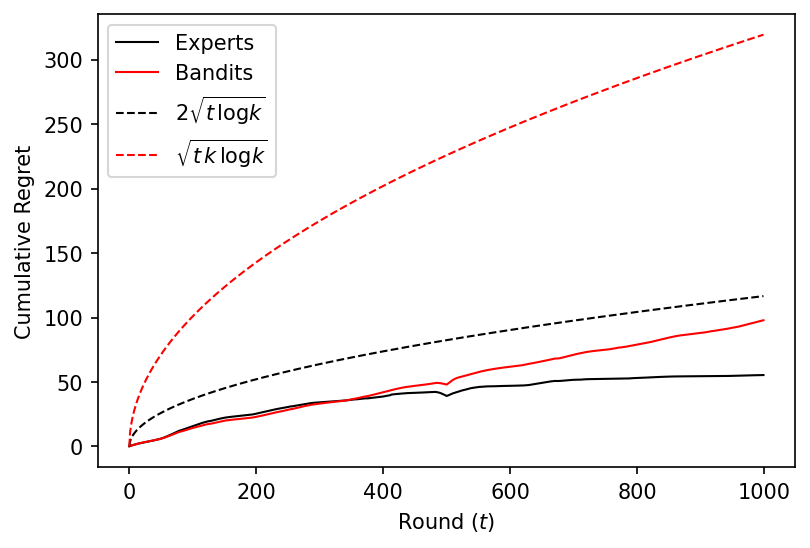

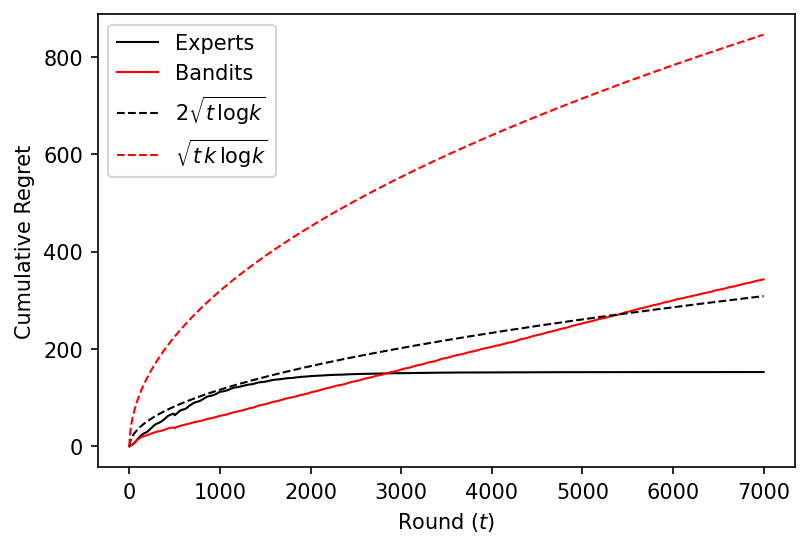

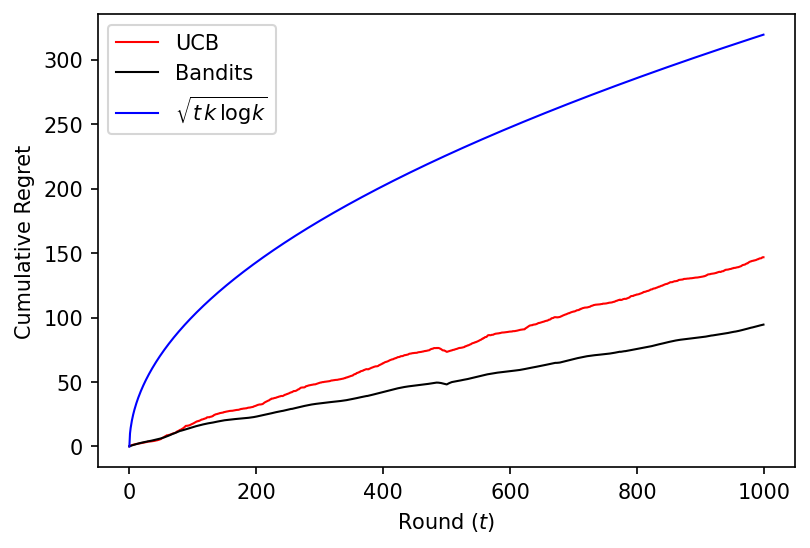

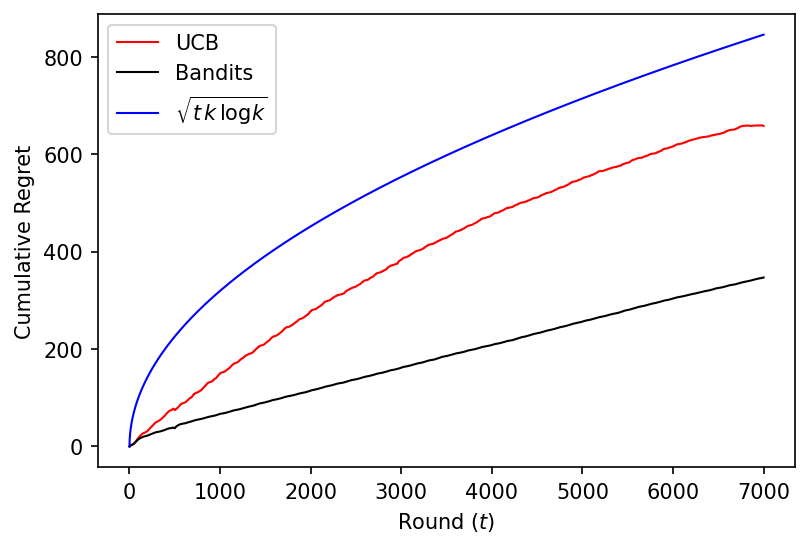

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def multiplicative_weights_experts(data,k,T,eta):
    w = np.ones((k,))           # Weights for each expert, w_i^t
    
    loss = np.zeros((k,T))      # Loss of each expert at time t, l_i^t

    L_exp = np.zeros((T,))      # Expected loss at time t

    for t in range(T):
        p = w/np.sum(w)         # Compute probability distributions
        I = np.random.choice(range(k),p=p).astype(int) # Choose expert I_t
        
        data_min = np.min(data[:,t])    # Find minimum at current time
        loss[:,t] = data[:,t]-data_min  # Compute current round losses
        w = (1-eta)**loss[:,t]*w        # Adjust weights

        L_exp[t] = np.sum(p*loss[:,t])  # Compute weighted sum of losses

    L_alg = np.cumsum(L_exp)    # Total expected loss at time t

    L = np.cumsum(loss,axis=1)  # Total losses of each expert up to time t
    L_opt = np.min(L,axis=0)    # Minimum loss w.r.t. i, at time t

    regret = L_alg - L_opt  # External regret
    return regret

def multiplicative_weights_bandits(data,k,T,eta,eps):
    w = np.ones((k,))           # Weights for each bandit at current time, w_i^t

    loss = np.zeros((k,T))      # Loss of each bandit at time t, l_i^t
    loss_th = np.zeros((k,T))   # Theoretical loss if any bandit was chosen

    L_exp = np.zeros((T,))      # Expected loss at time t

    for t in range(T):
        p = w/np.sum(w)         # Compute probability distributions
        q = (1-eps)*p + eps/k   # Transform probabilities and add exploration
        I = np.random.choice(range(k),p=q).astype(int)  # Choose bandit I_t

        data_min = np.min(data[:,t])            # Find minimum at current time
        loss[I,t] = (data[I,t] - data_min)/q[I] # Compute loss for I and scale
        loss_th[:,t] = (data[:,t] - data_min)   # Compute theoretical loss 
        w = (1-eta)**loss[:,t] * w              # Adjust weights

        L_exp[t] = np.sum(q*loss_th[:,t])       # Compute weighted sum of lossses

    L_alg = np.cumsum(L_exp)        # Total expected loss at time t

    L = np.cumsum(loss_th,axis=1)   # Total losses of each expert up to time t
    L_opt = np.min(L,axis=0)        # Minimum loss w.r.t. i, at time t

    regret = L_alg - L_opt  # External regret
    return regret

def upperConfidenceBound(data,k,T):
    X = np.zeros((k,T)) # Is 1 if ith bandit chosen at time t, 0 otherwise
    Q = np.zeros((k,))  # Number of times each bandit has been chosen
    mu = np.zeros((k,)) # Mean loss for each bandit

    ucb = np.ones((k,))*np.Inf  # Start at +Inf to explore all k first

    loss = np.zeros((k,T))  # Loss for each bandit at time t

    L_exp = np.zeros((T,))  # Experienced loss at time t

    for t in range(T):
        I = np.argmax(ucb)  # Choose bandit I_t with largest ucb

        data_min = np.min(data[:,t])    # Find minimum at current time

        loss[:,t] = data[:,t] - data_min

        X[I,t] = 1
        Q[I] += 1
        mu[I] = np.sum(-loss[I,:]*X[I,:])/Q[I]
        ucb[I] = mu[I] + np.sqrt(np.log(T)/Q[I])

        L_exp[t] = loss[I,t]

    L_alg = np.cumsum(L_exp)    # Total expected loss at time t

    L = np.cumsum(loss,axis=1)  # Total losses of each expert up to time t
    L_opt = np.min(L,axis=0)    # Minimum loss w.r.t. i, at time t

    regret = L_alg - L_opt  # External regret
    return regret


def plot_MW(data,T,save=False):
    k = data.shape[0]

    eta = np.sqrt(np.log(k)/T)
    regret_experts = multiplicative_weights_experts(data,k,T,eta)

    eta = (k*np.log(k)/T)**(1/3)
    eps = eta
    regret_bandits = multiplicative_weights_bandits(data,k,T,eta,eps)

    time = np.arange(T)
    plt.figure(dpi=150)
    plt.plot(regret_experts,'k',linewidth=1,label="Experts")
    plt.plot(regret_bandits,'r',linewidth=1,label="Bandits")
    plt.plot(time,2*np.sqrt(time*np.log(k)),'k--',linewidth=1,label="$2 \sqrt{t \, \log k}$")
    plt.plot(time,np.sqrt(time*k*np.log(k)),'r--',linewidth=1,label="$\sqrt{t \, k \, \log k}$")
    plt.xlabel('Round $(t)$')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    if save:
        plt.savefig(f'./Report/Images/mw_{T}.png',dpi=300,bbox_inches='tight')
    plt.show()


def plot_UCB(data,T,save=False):
    k = data.shape[0]


    eta = (k*np.log(k)/T)**(1/3)
    eps = eta
    regret_bandits = multiplicative_weights_bandits(data,k,T,eta,eps)

    regret_ucb = upperConfidenceBound(data,k,T)

    time = np.arange(T)
    plt.figure(dpi=150)
    plt.plot(regret_ucb,'r',linewidth=1,label="UCB")
    plt.plot(regret_bandits,'k',linewidth=1,label="Bandits")
    plt.plot(time,np.sqrt(time*k*np.log(k)),'b',linewidth=1,label="$\sqrt{t \, k \, \log k}$")
    plt.xlabel('Round $(t)$')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    if save:
        plt.savefig(f'./Report/Images/ucb_{T}.png',dpi=300,bbox_inches='tight')
    plt.show()


# Import dataset
file = open("Milano_timeseries.csv")
data = np.loadtxt(file,delimiter=',',dtype=float)
save = False

# Part I
plot_MW(data,1000,save)
plot_MW(data,7000,save)

# Part II
plot_UCB(data,1000,save)
plot_UCB(data,7000,save)